# Description of Data

Attribute Information:
1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

In [2]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook
from tqdm import tqdm

## for Deep-learing:
import keras
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
#from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout, Flatten, TimeDistributed

# Read the data 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv('/content/drive/MyDrive/Data/household_power_consumption.txt',
                 sep = ';', parse_dates = {'dt' : ['Date', 'Time']}, infer_datetime_format = True,
                 low_memory = False, na_values = ['nan','?'], index_col = 'dt')

 1) Note that data include 'nan' and '?' as a string. I converted both to numpy nan in importing stage (above) and treated both of them the same. 

2) I merged two columns 'Date' and 'Time' to 'dt'. 

3) I also converted in the above, the data to time-series type, by taking index to be the time. 

In [5]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2075259 entries, 2006-12-16 17:24:00 to 2010-11-26 21:02:00
Data columns (total 7 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   Global_active_power    float64
 1   Global_reactive_power  float64
 2   Voltage                float64
 3   Global_intensity       float64
 4   Sub_metering_1         float64
 5   Sub_metering_2         float64
 6   Sub_metering_3         float64
dtypes: float64(7)
memory usage: 126.7 MB


In [ ]:
df.dtypes

Global_active_power      float64
Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
dtype: object

In [ ]:
df.shape

(2075259, 7)

In [ ]:
df.describe()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
count,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06,2.049280e+06
mean,1.091615e+00,1.237145e-01,2.408399e+02,4.627759e+00,1.121923e+00,1.298520e+00,6.458447e+00
std,1.057294e+00,1.127220e-01,3.239987e+00,4.444396e+00,6.153031e+00,5.822026e+00,8.437154e+00
min,7.600000e-02,0.000000e+00,2.232000e+02,2.000000e-01,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.080000e-01,4.800000e-02,2.389900e+02,1.400000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.020000e-01,1.000000e-01,2.410100e+02,2.600000e+00,0.000000e+00,0.000000e+00,1.000000e+00
75%,1.528000e+00,1.940000e-01,2.428900e+02,6.400000e+00,0.000000e+00,1.000000e+00,1.700000e+01
max,1.112200e+01,1.390000e+00,2.541500e+02,4.840000e+01,8.800000e+01,8.000000e+01,3.100000e+01


In [ ]:
df.columns

Index(['Global_active_power', 'Global_reactive_power', 'Voltage',
       'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

#  Dealing with missing values

  'nan' with a test statistic

In [6]:
## finding all columns that have nan:

droping_list_all=[]
for j in range(0,7):
    if not df.iloc[:, j].notnull().all():
        droping_list_all.append(j)        
        #print(df.iloc[:,j].unique())
droping_list_all

[0, 1, 2, 3, 4, 5, 6]

In [7]:
# filling nan with mean in any columns

for j in range(0,7):        
        df.iloc[:,j]=df.iloc[:,j].fillna(df.iloc[:,j].mean())

# Data visualization

In [ ]:
# another sanity check to make sure that there are not more any nan
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [ ]:
df.Global_active_power.head()

dt
2006-12-16 17:24:00    4.216
2006-12-16 17:25:00    5.360
2006-12-16 17:26:00    5.374
2006-12-16 17:27:00    5.388
2006-12-16 17:28:00    3.666
Name: Global_active_power, dtype: float64

In [ ]:
df.Global_active_power.resample('D').mean()

dt
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
                ...   
2010-11-22    1.417733
2010-11-23    1.095511
2010-11-24    1.247394
2010-11-25    0.993864
2010-11-26    1.178230
Freq: D, Name: Global_active_power, Length: 1442, dtype: float64

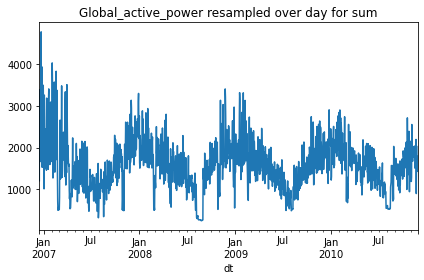

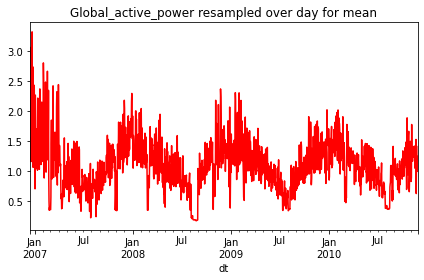

In [ ]:
df.Global_active_power.resample('D').sum().plot(title='Global_active_power resampled over day for sum') 
#df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day', color='red') 
plt.tight_layout()
plt.show()   

df.Global_active_power.resample('D').mean().plot(title='Global_active_power resampled over day for mean', color='red') 
plt.tight_layout()
plt.show()

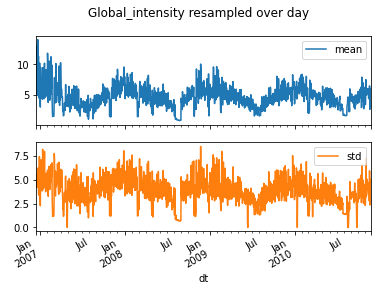

In [ ]:
### Below I show mean and std of 'Global_intensity' resampled over day 
r = df.Global_intensity.resample('D').agg(['mean', 'std'])
r.plot(subplots = True, title='Global_intensity resampled over day')
plt.show()

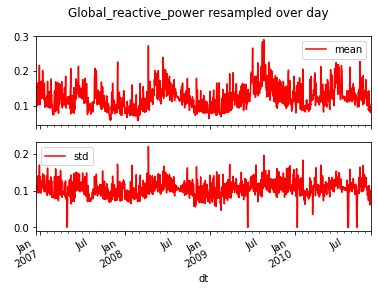

In [ ]:
### Below I show mean and std of 'Global_reactive_power' resampled over day
r2 = df.Global_reactive_power.resample('D').agg(['mean', 'std'])
r2.plot(subplots = True, title='Global_reactive_power resampled over day', color='red')
plt.show()

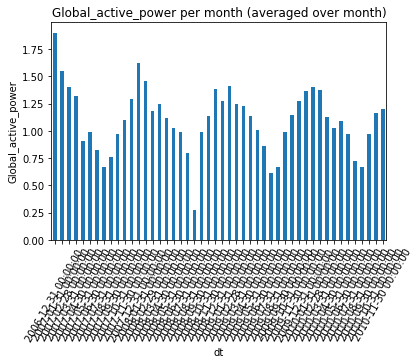

In [ ]:
### Sum of 'Global_active_power' resampled over month
# Sum of 'Global_active_power' resampled over month
df['Global_active_power'].resample('M').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per month (averaged over month)')
plt.show()

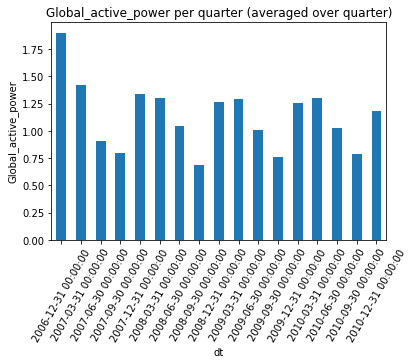

In [ ]:
## Mean of 'Global_active_power' resampled over quarter
df['Global_active_power'].resample('Q').mean().plot(kind='bar')
plt.xticks(rotation=60)
plt.ylabel('Global_active_power')
plt.title('Global_active_power per quarter (averaged over quarter)')
plt.show()

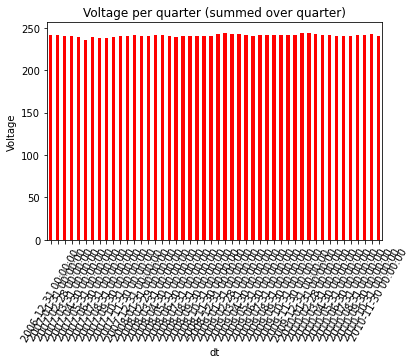

In [ ]:
## mean of 'Voltage' resampled over month
df['Voltage'].resample('M').mean().plot(kind='bar', color='red')
plt.xticks(rotation=60)
plt.ylabel('Voltage')
plt.title('Voltage per quarter (summed over quarter)')
plt.show()

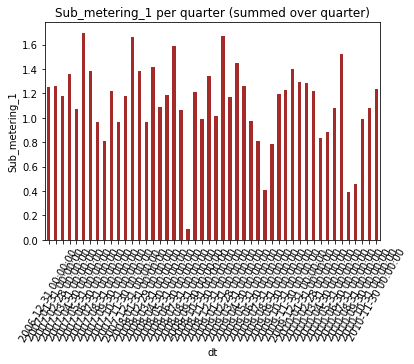

In [ ]:
df['Sub_metering_1'].resample('M').mean().plot(kind='bar', color='brown')
plt.xticks(rotation=60)
plt.ylabel('Sub_metering_1')
plt.title('Sub_metering_1 per quarter (summed over quarter)')
plt.show()

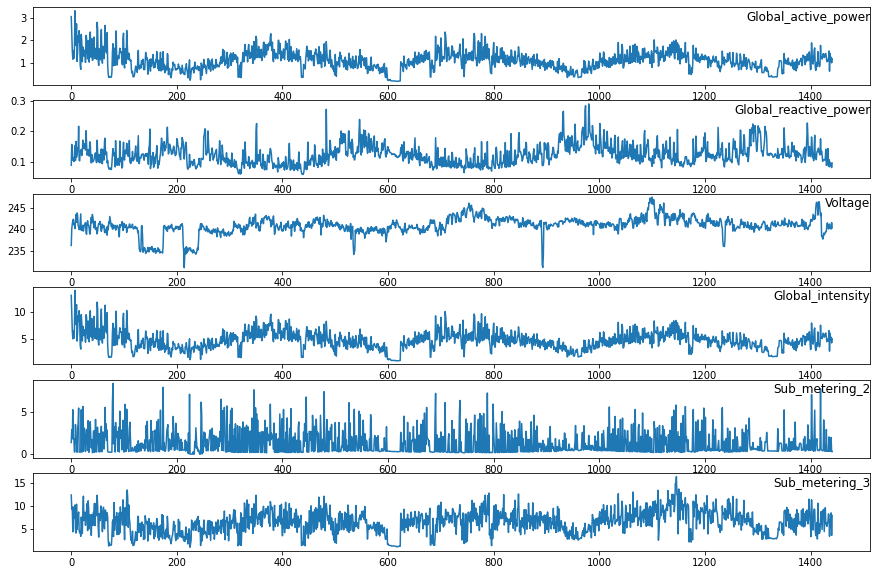

In [ ]:
# Below I compare the mean of different featuresresampled over day. 
# specify columns to plot
cols = [0, 1, 2, 3, 5, 6]
i = 1
groups=cols
values = df.resample('D').mean().values
# plot each column
plt.figure(figsize=(15, 10))
for group in groups:
	plt.subplot(len(cols), 1, i)
	plt.plot(values[:, group])
	plt.title(df.columns[group], y=0.75, loc='right')
	i += 1
plt.show()

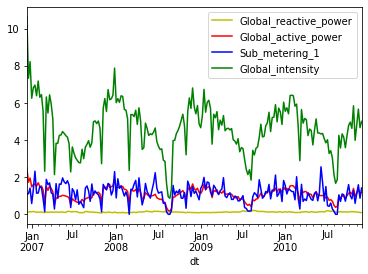

In [ ]:
## resampling over week and computing mean
df.Global_reactive_power.resample('W').mean().plot(color='y', legend=True)
df.Global_active_power.resample('W').mean().plot(color='r', legend=True)
df.Sub_metering_1.resample('W').mean().plot(color='b', legend=True)
df.Global_intensity.resample('W').mean().plot(color='g', legend=True)
plt.show()

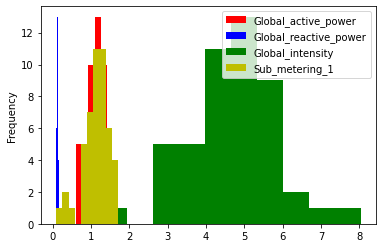

In [ ]:
# Below I show hist plot of the mean of different feature resampled over month 
df.Global_active_power.resample('M').mean().plot(kind='hist', color='r', legend=True )
df.Global_reactive_power.resample('M').mean().plot(kind='hist',color='b', legend=True)
#df.Voltage.resample('M').sum().plot(kind='hist',color='g', legend=True)
df.Global_intensity.resample('M').mean().plot(kind='hist', color='g', legend=True)
df.Sub_metering_1.resample('M').mean().plot(kind='hist', color='y', legend=True)
plt.show()

In [ ]:
data_returns = df.pct_change()
data_returns.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-12-16 17:25:00,0.271347,0.043062,-0.005152,0.250000,NaN,0.0,-0.058824
2006-12-16 17:26:00,0.002612,0.142202,-0.001455,0.000000,NaN,1.0,0.062500
2006-12-16 17:27:00,0.002605,0.008032,0.001929,0.000000,NaN,-0.5,0.000000
2006-12-16 17:28:00,-0.319599,0.051793,0.008300,-0.313043,NaN,0.0,0.000000


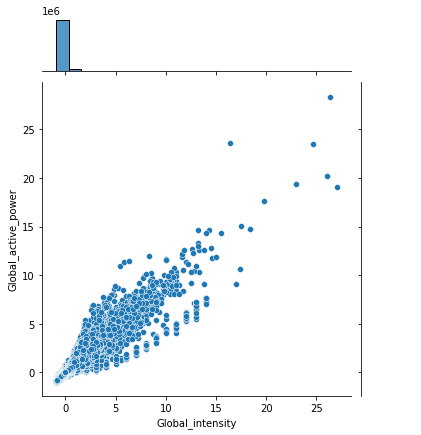

In [ ]:
## The correlations between 'Global_intensity', 'Global_active_power'
data_returns = df.pct_change()
sns.jointplot(x='Global_intensity', y='Global_active_power', data=data_returns)  

plt.show()

* From above two plots it is seen that 'Global_intensity' and 'Global_active_power' correlated. But 'Voltage', 'Global_active_power' are less correlated. This is important observation for machine learning purpose. 

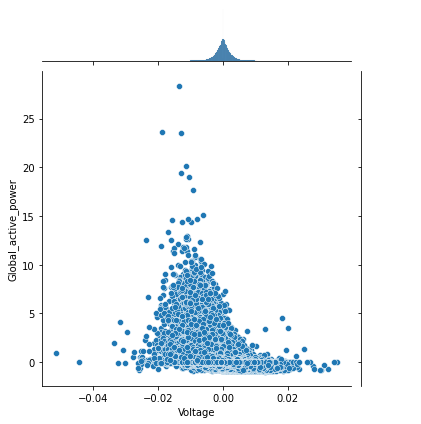

In [ ]:
## The correlations between 'Voltage' and  'Global_active_power'
sns.jointplot(x='Voltage', y='Global_active_power', data=data_returns)  
plt.show()

# Correlations among features

In [ ]:
df.corr(method = 'spearman')

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
Global_active_power,1.000000,0.266843,-0.327121,0.995525,0.324621,0.187453,0.611548
Global_reactive_power,0.266843,1.000000,-0.094692,0.294988,0.124556,0.431917,0.074071
Voltage,-0.327121,-0.094692,1.000000,-0.350782,-0.175124,-0.093525,-0.187378
Global_intensity,0.995525,0.294988,-0.350782,1.000000,0.326048,0.201651,0.608248
Sub_metering_1,0.324621,0.124556,-0.175124,0.326048,1.000000,0.116086,0.160727
Sub_metering_2,0.187453,0.431917,-0.093525,0.201651,0.116086,1.000000,0.054649
Sub_metering_3,0.611548,0.074071,-0.187378,0.608248,0.160727,0.054649,1.000000


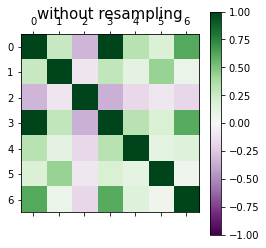

In [ ]:
# Correlations among columns
plt.matshow(df.corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('without resampling', size=15)
plt.colorbar()
plt.show()

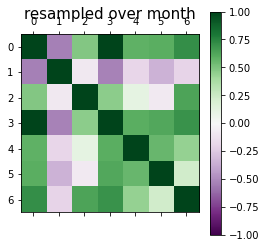

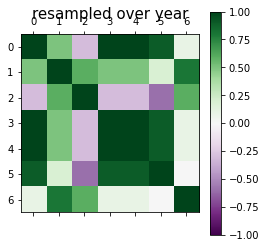

In [ ]:
# Correlations of mean of features resampled over months


plt.matshow(df.resample('M').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over month', size=15)
plt.colorbar()
plt.margins(0.02)
plt.matshow(df.resample('A').mean().corr(method='spearman'),vmax=1,vmin=-1,cmap='PRGn')
plt.title('resampled over year', size=15)
plt.colorbar()
plt.show()

* Correlations between feature is impacted by the kind off resampling we do and this is something to be remembered while designing the architecture

* We will be focusing on prediction of Global active power. Initially we will try to decompose the series to see if there is trend and seasonality present for this series.

# Smoothing methods

(1442, 7)


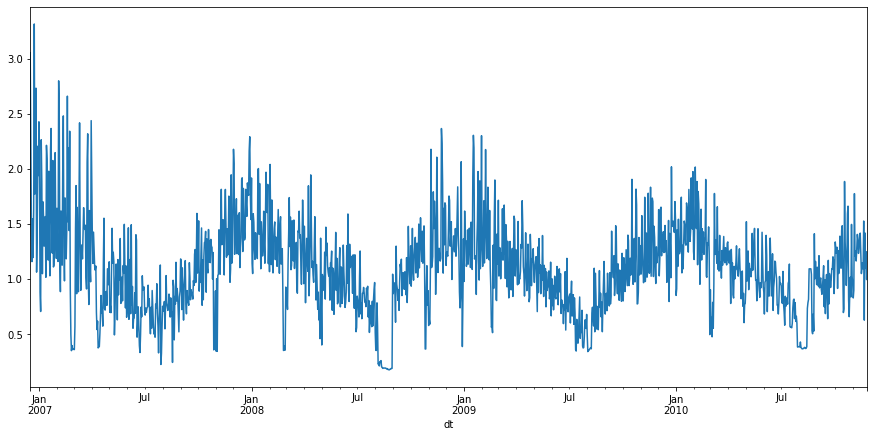

In [8]:
df_daily = df.resample('D').mean()
df_daily.head()
print(df_daily.shape)
plt.figure(figsize=(15, 7))
df_daily.Global_active_power.plot()

* We can see that active power usage dips down towards the middle of year and increases towards the end of year. This may be due to cold weather during this time and people spending more time in homes and the use of more heating appliances may be..

In [9]:
df_daily.Global_active_power

dt
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
                ...   
2010-11-22    1.417733
2010-11-23    1.095511
2010-11-24    1.247394
2010-11-25    0.993864
2010-11-26    1.178230
Freq: D, Name: Global_active_power, Length: 1442, dtype: float64

dt
2006-12-16    1.121642
2006-12-17    1.101108
2006-12-18    0.923556
2006-12-19    0.983688
2006-12-20    0.997302
                ...   
2010-11-22    0.923556
2010-11-23    0.983688
2010-11-24    0.997302
2010-11-25    0.909343
2010-11-26    0.963361
Freq: D, Name: Global_active_power, Length: 1442, dtype: float64
0.9999999999999896 0.07627597992641758


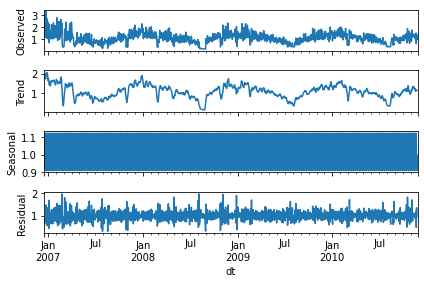

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
seas_decomp = seasonal_decompose(df_daily.Global_active_power, model='multiplicative')
seas_decomp.plot()
print(seas_decomp.seasonal)
print(seas_decomp.seasonal.mean(), seas_decomp.seasonal.std())

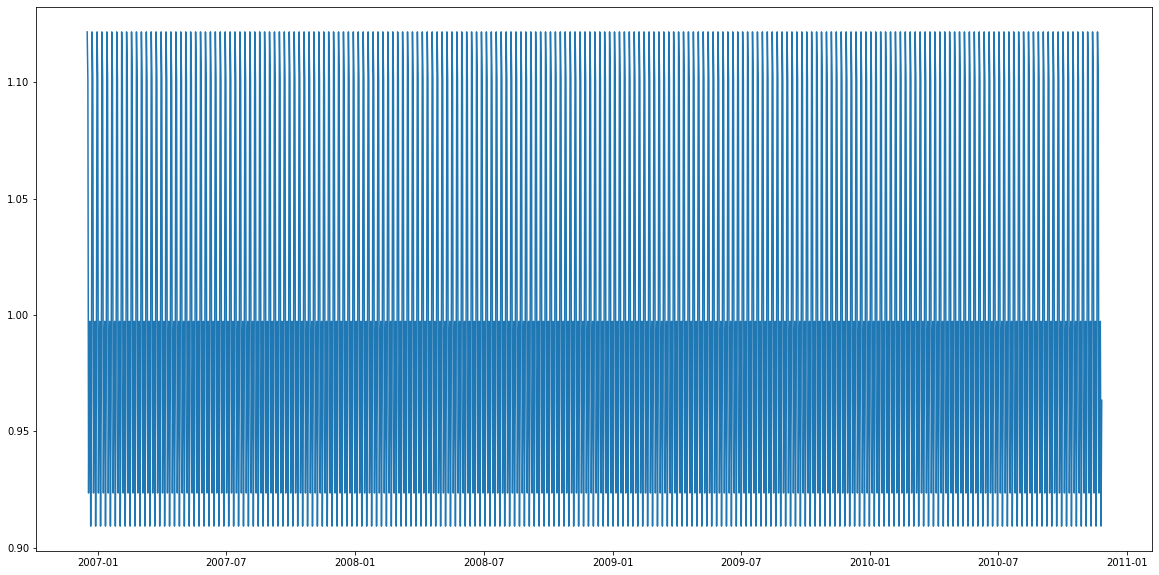

In [11]:
seas_decomp.seasonal
seas_decomp.seasonal.min()
seas_decomp.seasonal.max()
plt.figure(figsize = (20,10))
plt.plot(seas_decomp.seasonal)

* Why is the seasonality plot looking like this?? May be there isn't a significant seasonal pattern in data ????


In [ ]:
def moving_average(series, n):
    """
        Calculate average of last n observations
    """
    return np.average(series[-n:])


def plotMovingAverage(series, window, plot_intervals=False, scale=1.96, plot_anomalies=False):

    """
        series - dataframe with timeseries
        window - rolling window size 
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 

    """
    rolling_mean = series.rolling(window=window).mean()

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(window))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    # Plot confidence intervals for smoothed values
    if plot_intervals:
        mae = mean_absolute_error(series[window:], rolling_mean[window:])
        deviation = np.std(series[window:] - rolling_mean[window:])
        lower_bond = rolling_mean - (mae + scale * deviation)
        upper_bond = rolling_mean + (mae + scale * deviation)
        plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
        plt.plot(lower_bond, "r--")
        
        # Having the intervals, find abnormal values
        if plot_anomalies:
            anomalies = pd.DataFrame(index=series.index, columns=series.columns)
            anomalies[series<lower_bond] = series[series<lower_bond]
            anomalies[series>upper_bond] = series[series>upper_bond]
            plt.plot(anomalies, "ro", markersize=10)
        
    plt.plot(series[window:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

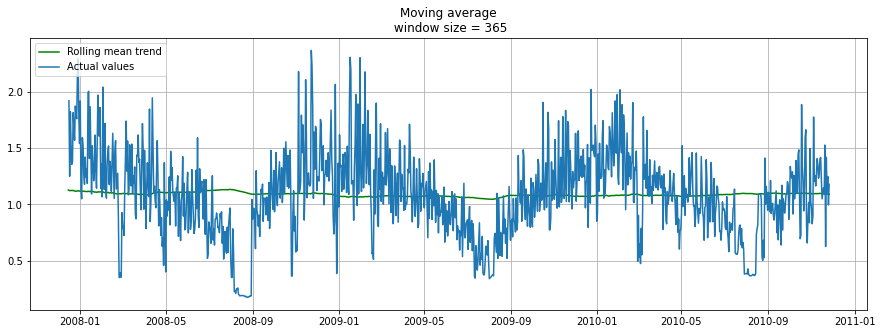

In [ ]:
moving_average(df_daily.Global_active_power, 365)
plotMovingAverage(df_daily.Global_active_power, 365) 

* When we kept the window for MA as a year, we can see that average consumption of power has remained similar throughout the years

**Triple exponential smoothing a.k.a. Holt-Winters**

In [ ]:
class HoltWinters:
    
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
        
        
    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  
    
    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # let's calculate season averages
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # let's calculate initial values
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

          
    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.initial_seasonal_components()
        
        for i in range(len(self.series)+self.n_preds):
            if i == 0: # components initialization
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])
                
                self.PredictedDeviation.append(0)
                
                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                
                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])
                continue
                
            if i >= len(self.series): # predicting
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])
                
                # when predicting we increase uncertainty on each step
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 
                
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])
                
                # Deviation is calculated according to Brutlag algorithm.
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])
                     
            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i%self.slen])

In [ ]:
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you

def timeseriesCVscore(params, series, loss_function=mean_squared_error, slen=24):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    tscv = TimeSeriesSplit(n_splits=3) 
    
    # iterating over folds, train model on each, forecast and calculate error
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen=slen, 
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()
        
        predictions = model.result[-len(test):]
        actual = values[test]
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [37]:
# Import the necessary metrics

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
%%time
from scipy.optimize import minimize
data = df_daily.Global_active_power[:-365] # leave some data for testing

# initializing model parameters alpha, beta and gamma
x = [0, 0, 0] 

# Minimizing the loss function 
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_squared_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1))
              )

# Take optimal values...
alpha_final, beta_final, gamma_final = opt.x
print(alpha_final, beta_final, gamma_final)

# ...and train the model with them, forecasting for the next 50 hours
model = HoltWinters(data, slen = 24, 
                    alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 50, scaling_factor = 3)
model.triple_exponential_smoothing()

0.1875446711781179 0.014817546469298892 0.1790801340426439
CPU times: user 9.39 s, sys: 25.7 ms, total: 9.42 s
Wall time: 9.4 s


In [ ]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

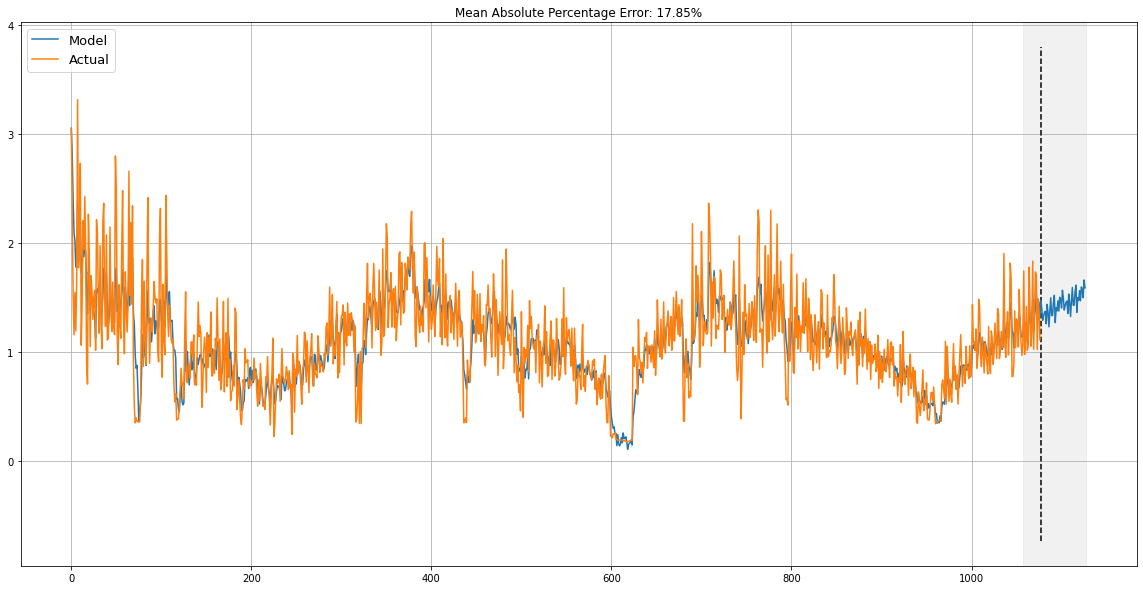

In [ ]:
plotHoltWinters(df_daily.Global_active_power[:-365])

# SARIMA

**Building SARIMA**

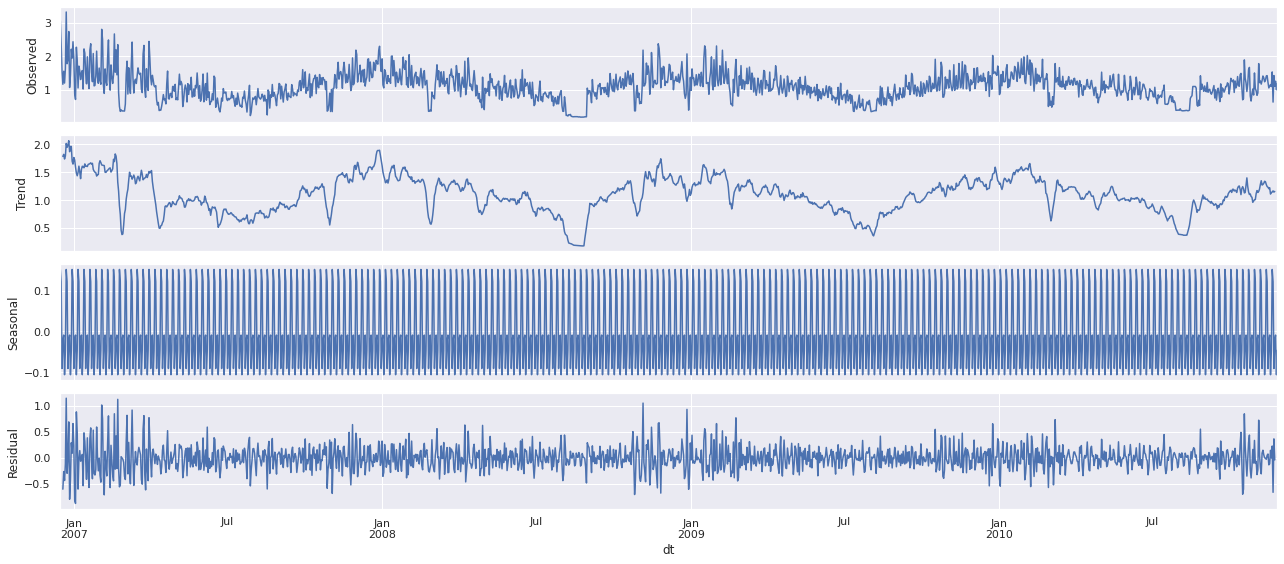

In [17]:
from pylab import rcParams

sns.set_theme()
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(df_daily.Global_active_power, model="additive")
fig = decomposition.plot()
plt.show()

In [12]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

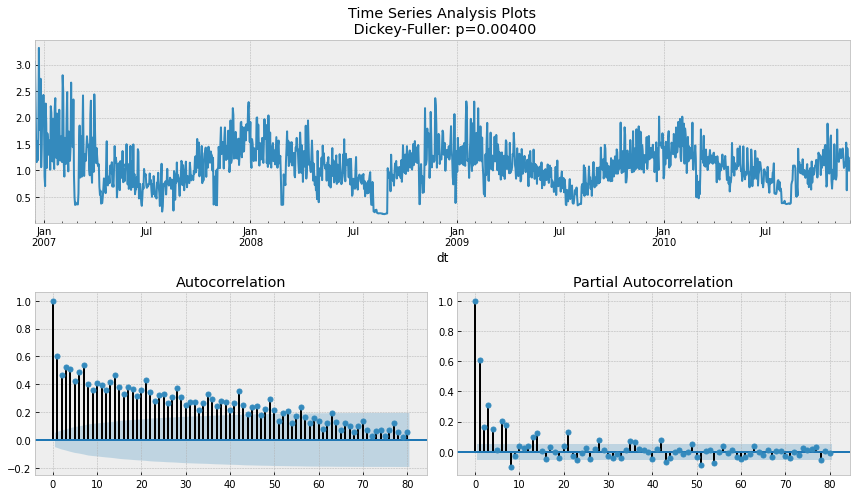

In [13]:
tsplot(df_daily.Global_active_power, lags=80)

* From the auto correlation plot we can see that at least till lag 8 there is a positive correlation of almost 0.5 or above.

* For PACF plot we can see that after lag 4 the values drop almost close to 0. So we can try using an AR term between 2-4 and try

* Series remains almost stationary with a constant mean and variance, we should be worried about a yearly seasonality

* To overcome this we will take a seasonal difference(1 year)


In [14]:
global_reactive_power_diff = df_daily.Global_active_power- df_daily.Global_active_power.shift(1)

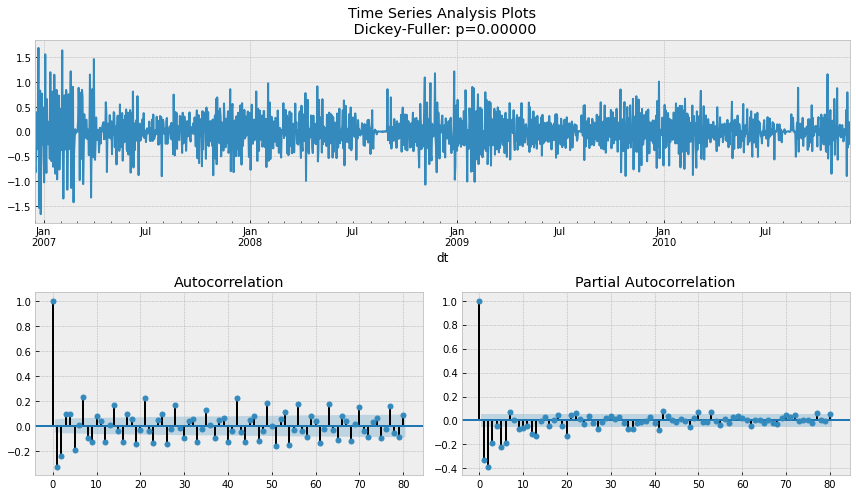

In [15]:
global_reactive_power_diff
tsplot(global_reactive_power_diff[1:], lags=80)

* It is now much better with the visible seasonality gone. However, the autocorrelation function still has too many significant lags. To remove them, we'll take first differences, subtracting the series from itself with lag 1.

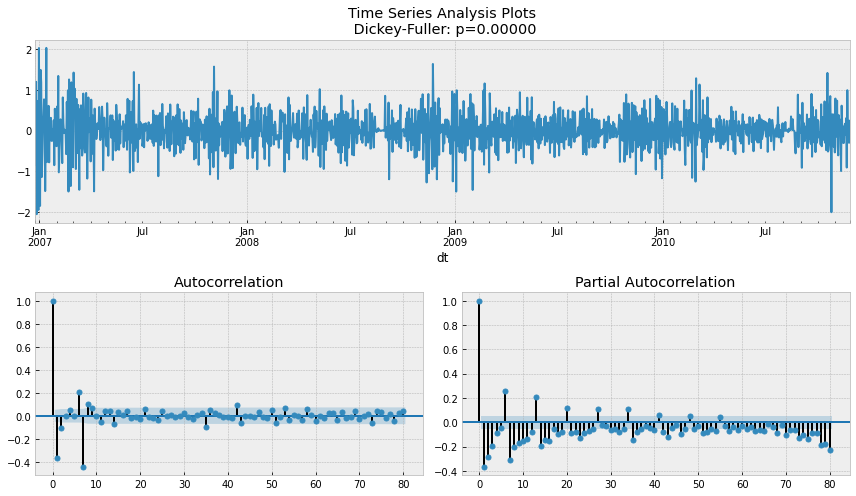

In [16]:
global_reactive_power_diff = global_reactive_power_diff - global_reactive_power_diff.shift(7)
tsplot(global_reactive_power_diff[7+1:], lags = 80)

* Better TS with values oscillating around 0

* p  is most probably 3 since it is the last significant lag on the PACF, after which, most others are not significant.

* d  equals 1 because we had first differences

* q  should be somewhere around 4-6 as well as seen on the ACF

* P  can be set as 1, as we only tested lags till 80

* D  again equals 1 because we performed seasonal differentiation

* Q  is probably 1. 

In [ ]:
df_daily.Global_active_power

dt
2006-12-16    3.053475
2006-12-17    2.354486
2006-12-18    1.530435
2006-12-19    1.157079
2006-12-20    1.545658
                ...   
2010-11-22    1.417733
2010-11-23    1.095511
2010-11-24    1.247394
2010-11-25    0.993864
2010-11-26    1.178230
Freq: D, Name: Global_active_power, Length: 1442, dtype: float64

In [19]:
# setting initial values and some bounds for them
p = range(2, 4)
d= range(1,2)
q = range(4, 6)
s = 7
# season length 7 days

# creating list with all the possible combinations of parameters
parameters = product(p, d, q)
seasonal_parameters = [(x[0], x[1], x[2], s) for x in list(product(p, d, q))]
parameters_list = list(parameters)
len(parameters_list)

4

In [ ]:
print(parameters_list)

[(2, 4, 1, 1), (2, 5, 1, 1), (3, 4, 1, 1), (3, 5, 1, 1)]


In [30]:
def optimizeSARIMA(series, parameters_list, seasonal_parameters):
    """
        Return dataframe with parameters and corresponding AIC
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")
    for param in tqdm(parameters_list):
      for seasonal_param in tqdm(seasonal_parameters):
          # we need try-except because on some combinations model fails to converge
          try:
              model=sm.tsa.statespace.SARIMAX(series, order=param, 
                                                seasonal_order=seasonal_param).fit(disp=-1)
          except:
              continue
          aic = model.aic
          # saving best model, AIC and parameters
          if aic < best_aic:
              best_model = model
              best_aic = aic
              best_param = param
              best_seasonal_param = seasonal_param
          results.append([param, seasonal_param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'seasonal_param','aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [24]:
model=sm.tsa.statespace.SARIMAX(df_daily.Global_active_power, order=(2, 1, 2), 
                                            seasonal_order=(1, 1,1, 7)).fit(disp=-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [31]:
%%time
result_table = optimizeSARIMA(df_daily.Global_active_power, parameters_list, seasonal_parameters)

  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 25%|██▌       | 1/4 [01:16<03:48, 76.01s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 50%|█████     | 2/4 [03:11<03:19, 99.51s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

 75%|███████▌  | 3/4 [04:36<01:32, 92.71s/it]/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)

  0%|       

CPU times: user 33min 51s, sys: 22min 25s, total: 56min 16s
Wall time: 29min 43s


In [32]:
result_table.head()

,parameters,seasonal_param,aic
0,"(3, 1, 4)","(2, 1, 5, 7)",487.150034
1,"(2, 1, 5)","(2, 1, 4, 7)",487.881115
2,"(2, 1, 5)","(2, 1, 5, 7)",487.927893
3,"(3, 1, 4)","(3, 1, 5, 7)",488.744292
4,"(2, 1, 5)","(3, 1, 5, 7)",490.412232


In [33]:
# set the parameters that give the lowest AIC
p, d, q = result_table.parameters[0]
P, D, Q, s = result_table.seasonal_param[0]

best_model=sm.tsa.statespace.SARIMAX(df_daily.Global_active_power, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                                 Statespace Model Results                                
Dep. Variable:               Global_active_power   No. Observations:                 1442
Model:             SARIMAX(3, 1, 4)x(2, 1, 5, 7)   Log Likelihood                -228.575
Date:                           Tue, 31 Aug 2021   AIC                            487.150
Time:                                   23:40:54   BIC                            566.173
Sample:                               12-16-2006   HQIC                           516.655
                                    - 11-26-2010                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0209      0.096      0.217      0.829      -0.168       0.210
ar.L2         -0.3880      0.090     -4.330

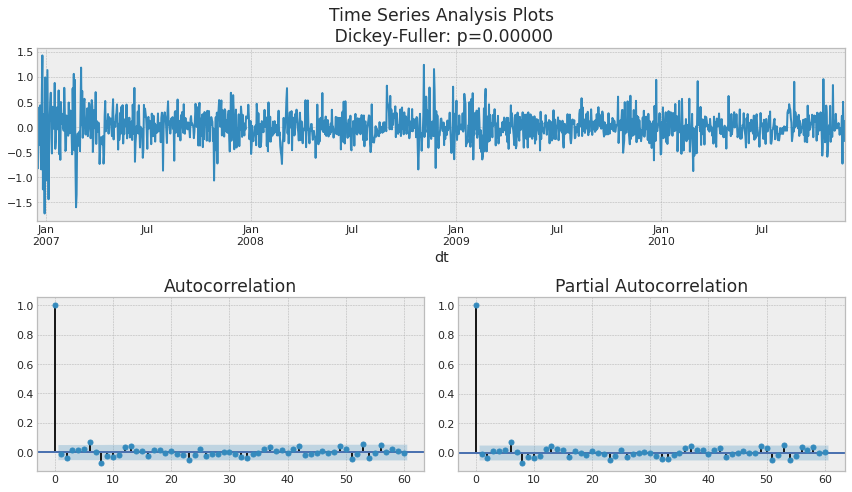

In [43]:
tsplot(best_model.resid[0+1:], lags=60)

In [49]:
def plotSARIMA(series, model, n_steps):
    """
        Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future
        
    """
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    #print(data)
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    #plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.title("Household Power Consumption - Actual vs Predicted")
    plt.plot(forecast, color='r', label="predicted")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True);

In [ ]:
print(type(df_daily.Global_active_power))

<class 'pandas.core.series.Series'>


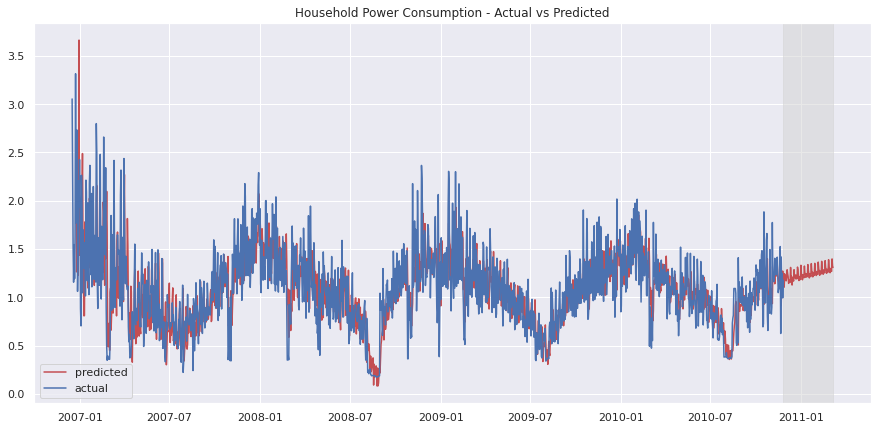

In [50]:
plotSARIMA(pd.DataFrame(df_daily.Global_active_power), best_model, 100)

In [41]:
df_daily.Global_active_power[-182:]

dt
2010-05-29    1.423478
2010-05-30    1.156736
2010-05-31    0.930876
2010-06-01    0.881225
2010-06-02    0.681179
                ...   
2010-11-22    1.417733
2010-11-23    1.095511
2010-11-24    1.247394
2010-11-25    0.993864
2010-11-26    1.178230
Freq: D, Name: Global_active_power, Length: 182, dtype: float64

In [44]:
mean_absolute_percentage_error(df_daily.Global_active_power[-182:], best_model.fittedvalues[-183:-1])

19.565455572497008

In [45]:
mean_absolute_error(df_daily.Global_active_power[-182:], best_model.fittedvalues[-183:-1])

0.19084502940988948

In [46]:
np.sqrt(mean_squared_error(df_daily.Global_active_power[-182:], best_model.fittedvalues[-183:-1]))

0.2519752835812975